In [1]:
import jax
import jax.numpy as jnp
import jax.random as jr
from jax import grad, jit, vmap
from jax.scipy.ndimage import map_coordinates
import jax.lax as lax
import optax
from tqdm.auto import trange, tqdm
import matplotlib.pyplot as plt
import dLux as dl
import dLux.utils as dlu
import dLuxToliman as dlT
import math
import numpy as np
import equinox as eqx
import zodiax as zdx
import optax

# This was made using Connor's help - I think it's mostly a direct copy of code he already has in his repo.
phase_mask = np.load("/Users/angusrutherford/Desktop/dLuxToliman/new_diffractive_pupil.npy")

mask = dl.Optic(phase=phase_mask)

wavefront_npix = 2000 # 2000 # Wavefront number of pixels
aperture_diam = 0.125 # Diameter of aperture (m)
oversample = 1
coords = dlu.pixel_coords(wavefront_npix * oversample, aperture_diam)
secondary_diam = 0.032 # Diameter of secondary mirror (m)
spider_width = 0.002 # Spider width (m)
#psf_npixels = 256 #3600 # Number of pixels across one axis on detector
psf_npixels = 100
pixel_scale = 0.375 # Converting angle between binary source to angle on detector
primary = dlu.circle(coords, aperture_diam/2)
secondary = dlu.circle(coords, secondary_diam/2, invert=True)
angles = [0, 120, 240]
spiders = dlu.spider(coords, spider_width, angles)

aperture = dlu.combine([primary, secondary, spiders], oversample)

# Define the optical layers
layers = [("aperture", dl.layers.Optic(aperture, normalise=True)), ("phase_mask", mask)]

# Construct the optics object
# optics = dl.AngularOpticalSystem(wavefront_npix, aperture_diam, layers, psf_npixels, pixel_scale, oversample)
optics = dlT.TolimanOpticalSystem(
    wavefront_npix,
    psf_npixels,
    oversample,
    pixel_scale,
    mask=mask,
    radial_orders=[6]
    )

In [2]:
# optics was already constructed earlier
unit_flux_source = dlT.AlphaCen(
    n_wavels       = 3,
    separation     = 10.0,
    position_angle = 90.0,
    x_position     = 0.0,
    y_position     = 0.0,
    log_flux       = 0.0,          # unit‑flux PSF shape
    contrast       = 3.37,
    bandpass       = (530, 640),
)
unit_instr = dlT.Toliman(optics, unit_flux_source)
psf_unit   = unit_instr.model()             # shape‑only PSF
true_log_flux = 7.832
true_flux     = 10.0 ** true_log_flux           # linear photons / “counts”

# noiseless expectation
expect_counts = true_flux * psf_unit            # same shape as PSF

# ---- add photon noise (Poisson) + small read noise (Gaussian σ=5 e−) ----
key_ph, key_rd = jr.split(jr.PRNGKey(0))

data_poisson   = jr.poisson(key_ph, lam=expect_counts)
data_noisy     = data_poisson + 5.0 * jr.normal(key_rd, data_poisson.shape)

# convert to float32 for gradients
psf_obs = expect_counts.astype(jnp.float32)        # THIS is what we "observe"
def model_psf(log_flux):
    """Return model image for a candidate log₁₀ flux (scalar)."""
    return (10.0 ** log_flux) * psf_unit

def loss_fn(log_flux):
    pred = model_psf(log_flux)
    return jnp.mean((pred - psf_obs) ** 2)      # simple MSE

grad_fn = jax.grad(loss_fn)
log_flux_param = jnp.array(11.0)          # deliberately bad initial guess
optim  = optax.adam(1e-1)
state  = optim.init(log_flux_param)

history = []
loss_history = []
for step in range(20000):
    g = grad_fn(log_flux_param)
    updates, state = optim.update(g, state)
    log_flux_param = optax.apply_updates(log_flux_param, updates)
    history.append(float(log_flux_param))
    loss = loss_fn(log_flux_param)
    loss_history.append(float(loss))
    if step % 100 == 0:
        print(f"step {step:4d} | log_flux = {float(log_flux_param):.5f} | loss = {float(loss):.3e}")
    # if log_flux_param - true_log_flux < 1e-3:
    #     print("Converged!")
    #     break

psf_obs = data_noisy.astype(jnp.float32)        # THIS is what we "observe"
def model_psf(log_flux):
    """Return model image for a candidate log₁₀ flux (scalar)."""
    return (10.0 ** log_flux) * psf_unit

def loss_fn(log_flux):
    pred = model_psf(log_flux)
    return jnp.mean((pred - psf_obs) ** 2)      # simple MSE

grad_fn = jax.grad(loss_fn)
log_flux_param = jnp.array(11.0)          # deliberately bad initial guess
optim  = optax.adam(1e-1)
state  = optim.init(log_flux_param)

history_two = []
loss_history_two = []
for step in range(20000):
    g = grad_fn(log_flux_param)
    updates, state = optim.update(g, state)
    log_flux_param = optax.apply_updates(log_flux_param, updates)
    history_two.append(float(log_flux_param))
    loss = loss_fn(log_flux_param)
    loss_history_two.append(float(loss))
    if step % 100 == 0:
        print(f"step {step:4d} | log_flux = {float(log_flux_param):.5f} | loss = {float(loss):.3e}")

step    0 | log_flux = 10.90000 | loss = 1.519e+14
step  100 | log_flux = 9.58154 | loss = 3.387e+11
step  200 | log_flux = 9.46940 | loss = 1.999e+11
step  300 | log_flux = 9.37753 | loss = 1.295e+11
step  400 | log_flux = 9.30240 | loss = 9.063e+10
step  500 | log_flux = 9.23937 | loss = 6.705e+10
step  600 | log_flux = 9.18519 | loss = 5.168e+10
step  700 | log_flux = 9.13766 | loss = 4.108e+10
step  800 | log_flux = 9.09530 | loss = 3.344e+10
step  900 | log_flux = 9.05704 | loss = 2.774e+10
step 1000 | log_flux = 9.02210 | loss = 2.337e+10
step 1100 | log_flux = 8.98990 | loss = 1.993e+10
step 1200 | log_flux = 8.96002 | loss = 1.719e+10
step 1300 | log_flux = 8.93208 | loss = 1.495e+10
step 1400 | log_flux = 8.90583 | loss = 1.311e+10
step 1500 | log_flux = 8.88104 | loss = 1.157e+10
step 1600 | log_flux = 8.85752 | loss = 1.027e+10
step 1700 | log_flux = 8.83513 | loss = 9.158e+09
step 1800 | log_flux = 8.81373 | loss = 8.207e+09
step 1900 | log_flux = 8.79323 | loss = 7.383e+09

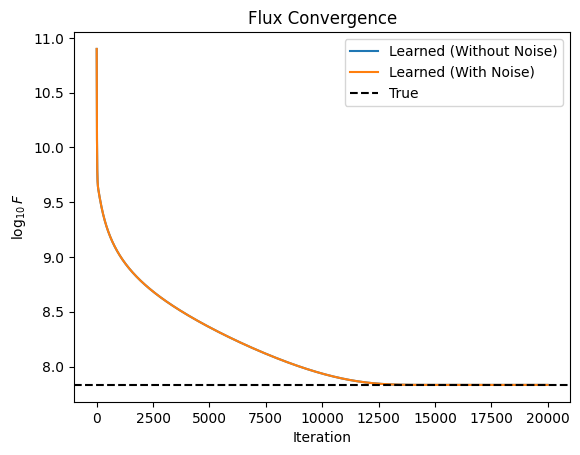

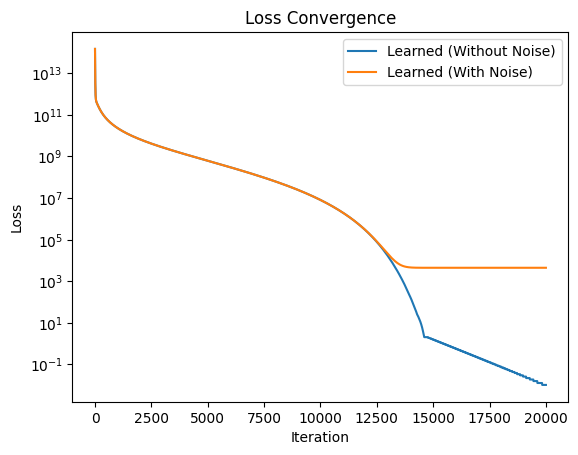

In [3]:
plt.plot(history, label="Learned (Without Noise)")
plt.plot(history_two, label="Learned (With Noise)")
plt.axhline(true_log_flux, color="k", ls="--", label="True")
plt.xlabel("Iteration"); plt.ylabel(r"$\log_{10} F$")
plt.title("Flux Convergence")
plt.legend(); plt.show()


plt.plot(loss_history, label="Learned (Without Noise)")
plt.plot(loss_history_two, label="Learned (With Noise)")
plt.xlabel("Iteration"); plt.ylabel("Loss")
plt.title("Loss Convergence")
plt.yscale("log")
plt.legend(); plt.show()